# NCAA Track and Field Championships

In [1]:
from typing import Tuple, List
from os import makedirs

import pandas as pd
import numpy as np

pd.options.mode.copy_on_write = True

In [2]:
FINAL_YEAR = 2024
SEASONS = ['Indoor', 'Outdoor']

def download_flashresults(season: str, final_year: int = FINAL_YEAR, export: bool = False) -> Tuple[pd.DataFrame]:
    '''Download the FlashResults NCAA Championship Results.

    Params:
      -  final_year (`int`): the last year to download (2021 is the earliest, ladf istypically the current year)
      -  season (`str`): the season to download ('Outdoor' or 'Indoor')
      -  export (`bool`): export the data as CSV files to the data directory, default is `False`

    Returns:
      -  data (`Tuple[pd.DataFrame]`): a tuple of the women's and men's dataframes for a season across all selected years.
    '''
    dfs_f = None
    dfs_m = None

    for year in range(2021, final_year + 1):
        if season not in SEASONS:
            raise ValueError('Please choose a valid competition season.')

        if (year == 2024) & (season == 'Outdoor'):
            continue 

        root: str = f'https://flashresults.ncaa.com/{season}/{year}/scores_by_event.htm'    
        df_f = pd.read_html(root)[0]
        df_m = pd.read_html(root)[1]

        if df_f is None:
            dfs_f = df_f.assign(year=year, season=season)
            continue
        
        if df_m is None:
            dfs_m = df_m.assign(year=year, season=season)
            continue

        dfs_f = pd.concat([dfs_f, df_f.assign(year=year, season=season)])
        dfs_m = pd.concat([dfs_m, df_m.assign(year=year, season=season)])

    if export:
        makedirs('data', exist_ok=True)
        dfs_f.to_csv(f'data/DI_women_2021-{year}_{season}.csv', index=False)
        dfs_m.to_csv(f'data/DI_men_2021-{year}_{season}.csv', index=False)

    return (clean_columns(dfs_f.reset_index(drop=True), sex='f', season=season), 
            clean_columns(dfs_m.reset_index(drop=True), sex='m', season=season))


def clean_columns(df: pd.DataFrame, sex: str, season: str) -> pd.DataFrame:
    '''Rename columns and convert event point columns to floats.

    Params:
      -  df (`pd.DataFrame`): A pandas DataFrame of championship results
      -  sex (`str`): the sex that the championship results table belongs to. Options: 'f' or 'm'
      -  season (`str`): the season to download Options: 'Outdoor' or 'Indoor'

    Returns:
      -  df (`pd.DataFrame`): the input pandas DataFrame reformatted for mathematical operations and future modeling

    '''
    sex_prefix = 'Women' if sex == 'f' else 'Men'
    n_events = 21 if season == 'Outdoor' else 17

    try:
        df = df.drop(columns=['Unnamed: 1'])
        df.rename(columns={'Place': 'place',
                           f'{sex_prefix} [{n_events} of {n_events}]': f'team_{sex_prefix[0].lower()}',
                           'Total': 'total_points'},
                  inplace=True)
    except KeyError:
        df.rename(columns={'Place': 'place',
                           f'{sex_prefix} [{n_events} of {n_events}]': f'team_{sex_prefix[0].lower()}',
                           'Total': 'total_n_events'},
                  inplace=True)

    event_cols = list(df.columns)[3:-2]

    for col in event_cols:
        df.loc[df[col] == '-', col] = float('NaN')
        df[col] = df[col].astype('float')

    return df.reset_index(drop=True)

In [3]:
def add_metrics(df: pd.DataFrame) -> pd.DataFrame:
    '''Add modeling metrics to the dataset. 
    
    General Metrics:
    Discipline Metrics:
    Interdiscipline Metrics:
    Track vs Field Metrics:
    
    Params:
      -  df (`pd.DataFrame`): the dataset to calculate metrics from
      
    Returns:
      -  df (`pd.DataFrame'): the dataset with expanded columns for all the metrics'''

    sprints = ['60', '100', '200', '4x1R']
    hurdles = ['60H', '100H', '110H', '400H']
    mid_distance = ['400', '800', '1500', '1Mile', '4X4R']
    distance = ['3000', '3000SC', '5000', '10000', 'DMR']
    relays = ['4x1R', '4X4R', 'DMR']
    jumps = ['HJ', 'PV', 'LJ', 'TJ']
    throws = ['SP', 'WT', 'DT', 'HT', 'JT']
    multi = ['Pent', 'Hep', 'Dec']
    track = sprints + hurdles + mid_distance + distance
    field = jumps + throws + multi

    event_cols = list(df.columns)[3:-2]

    def get_columns(discipline: List[str]) -> List[str]:
        return list(filter(lambda x: x in discipline, event_cols))

    def get_meta_columns(metacolumn: List[str]) -> List[str]:
        return list(filter(lambda x: x in metacolumn, list(df.columns)))

    # Overall Metrics
    df['mean_pts_per_event'] = df[event_cols].agg('mean', axis=1)
    df['median_pts_per_event'] = df[event_cols].agg('median', axis=1)
    df['std_pts_per_event'] = df[event_cols].agg('std', axis=1)
    df['n_events_participated'] = df[event_cols].agg('count', axis=1)
    df['n_events_6_pts_or_more'] = df[event_cols].apply(lambda x: x >= 6).agg('sum', axis=1)
    df['n_events_5_pts_or_more'] = df[event_cols].apply(lambda x: x >= 5).agg('sum', axis=1)
    df['n_events_4_pts_or_more'] = df[event_cols].apply(lambda x: x >= 4).agg('sum', axis=1)

    # Intradiscipline metrics
    df['points_sprints'] = df[get_columns(sprints)].agg('sum', axis=1)
    df['mean_pts_sprints'] = df[get_columns(sprints)].agg('mean', axis=1)
    df['median_pts_sprints'] = df[get_columns(sprints)].agg('median', axis=1)
    df['std_pts_sprints'] = df[get_columns(sprints)].agg('std', axis=1)
    df['n_events_sprints'] = df[get_columns(sprints)].agg('count', axis=1)

    df['points_hurdles'] = df[get_columns(hurdles)].agg('sum', axis=1)
    df['mean_pts_hurdles'] = df[get_columns(hurdles)].agg('mean', axis=1)
    df['median_pts_hurdles'] = df[get_columns(hurdles)].agg('median', axis=1)
    df['std_pts_hurdles'] = df[get_columns(hurdles)].agg('std', axis=1)
    df['n_events_hurdles'] = df[get_columns(hurdles)].agg('count', axis=1)

    df['points_mid_distance'] = df[get_columns(mid_distance)].agg('sum', axis=1)
    df['mean_pts_mid_distance'] = df[get_columns(mid_distance)].agg('mean', axis=1)
    df['median_pts_mid_distance'] = df[get_columns(mid_distance)].agg('median', axis=1)
    df['std_pts_mid_distance'] = df[get_columns(mid_distance)].agg('std', axis=1)
    df['n_events_mid_distance'] = df[get_columns(mid_distance)].agg('count', axis=1)

    df['points_distance'] = df[get_columns(distance)].agg('sum', axis=1)
    df['mean_pts_distance'] = df[get_columns(distance)].agg('mean', axis=1)
    df['median_pts_distance'] = df[get_columns(distance)].agg('median', axis=1)
    df['std_pts_distance'] = df[get_columns(distance)].agg('std', axis=1)
    df['n_events_distance'] = df[get_columns(distance)].agg('count', axis=1)

    df['points_relays'] = df[get_columns(relays)].agg('sum', axis=1)
    df['mean_pts_relays'] = df[get_columns(relays)].agg('mean', axis=1)
    df['median_pts_relays'] = df[get_columns(relays)].agg('median', axis=1)
    # df['std_pts_relays'] = df[get_columns(relays)].agg('std', axis=1)
    df['n_events_relays'] = df[get_columns(relays)].agg('count', axis=1)

    df['points_jumps'] = df[get_columns(jumps)].agg('sum', axis=1)
    df['mean_pts_jumps'] = df[get_columns(jumps)].agg('mean', axis=1)
    df['median_pts_jumps'] = df[get_columns(jumps)].agg('median', axis=1)
    df['std_pts_jumps'] = df[get_columns(jumps)].agg('std', axis=1)
    df['n_events_jumps'] = df[get_columns(jumps)].agg('count', axis=1)

    df['points_throws'] = df[get_columns(throws)].agg('sum', axis=1)
    df['mean_pts_throws'] = df[get_columns(throws)].agg('mean', axis=1)
    df['median_pts_throws'] = df[get_columns(throws)].agg('median', axis=1)
    df['std_pts_throws'] = df[get_columns(throws)].agg('std', axis=1)
    df['n_events_throws'] = df[get_columns(throws)].agg('count', axis=1)

    df['points_multi'] = df[get_columns(multi)].agg('sum', axis=1)
    df['mean_pts_multi'] = df[get_columns(multi)].agg('mean', axis=1)
    df['median_pts_multi'] = df[get_columns(multi)].agg('median', axis=1)
    # df['std_pts_multi'] = df[get_columns(multi)].agg('std', axis=1)
    df['n_events_multi'] = df[get_columns(multi)].agg('count', axis=1)

    df['points_track'] = df[get_columns(track)].agg('sum', axis=1)
    df['mean_pts_track'] = df[get_columns(track)].agg('mean', axis=1)
    df['median_pts_track'] = df[get_columns(track)].agg('median', axis=1)
    df['std_pts_track'] = df[get_columns(track)].agg('std', axis=1)
    df['n_events_track'] = df[get_columns(track)].agg('count', axis=1)

    df['points_field'] = df[get_columns(field)].agg('sum', axis=1)
    df['mean_pts_field'] = df[get_columns(field)].agg('mean', axis=1)
    df['median_pts_field'] = df[get_columns(field)].agg('median', axis=1)
    df['std_pts_field'] = df[get_columns(field)].agg('std', axis=1)
    df['n_events_field'] = df[get_columns(field)].agg('count', axis=1)

    # Interdiscipline Metrics
    discipline_points = ['points_sprints', 'points_hurdles', 'points_mid_distance',
                        'points_distance', 'points_relays', 'points_jumps',
                        'points_throws', 'points_multi']
    discipline_n_events = ['n_events_sprints', 'n_events_hurdles', 'n_events_mid_distance',
                        'n_events_distance', 'n_events_relays', 'n_events_jumps',
                        'n_events_throws', 'n_events_multi']

    df['mean_pts_disciplines'] = df[get_meta_columns(discipline_points)].agg('mean', axis=1)
    df['median_pts_disciplines'] = df[get_meta_columns(discipline_points)].agg('median', axis=1)
    df['std_pts_disciplines'] = df[get_meta_columns(discipline_points)].agg('std', axis=1)

    df['mean_n_disciplines'] = df[get_meta_columns(discipline_n_events)].agg('mean', axis=1)
    df['median_n_disciplines'] = df[get_meta_columns(discipline_n_events)].agg('median', axis=1)
    df['std_n_disciplines'] = df[get_meta_columns(discipline_n_events)].agg('std', axis=1)

    # Track vs Field Metrics
    df['track_vs_field_differential'] = df['points_track'] - df['points_field']  # Negative = more field points
    df['track_vs_field_mean_differential'] = df['mean_pts_track'] - df['mean_pts_field']  # Negative = more field points
    df['track_vs_field_n_differential'] = df['n_events_track'] - df['n_events_field']  # Negative = compete more field events
    df['track_vs_field_track_proportion'] = df['points_track'] / df['total_points']
    df['track_vs_field_field_proportion'] = 1 - df['track_vs_field_track_proportion']

    return df.fillna(0)

### Download Data and Add Metrics

In [4]:
dfs_f_o, dfs_m_o = download_flashresults(season='Outdoor')
dfs_f_i, dfs_m_i = download_flashresults(season='Indoor')

dfs_f_o = add_metrics(dfs_f_o)

## Visualize Datasets

### Women's Outdoor Championships

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmp
import seaborn as sns
from adjustText import adjust_text

sns.set_theme(style='whitegrid')  #, palette='viridis')

#### t-SNE

In [6]:
from sklearn.manifold import TSNE

women_outdoor_tsne = TSNE(n_components=2, 
                          learning_rate='auto',
                          perplexity=45,
                          init='pca', 
                          random_state=69420).fit_transform(dfs_f_o.select_dtypes(['float', 'int']))

dfs_f_o[['tsne_x', 'tsne_y']] = women_outdoor_tsne

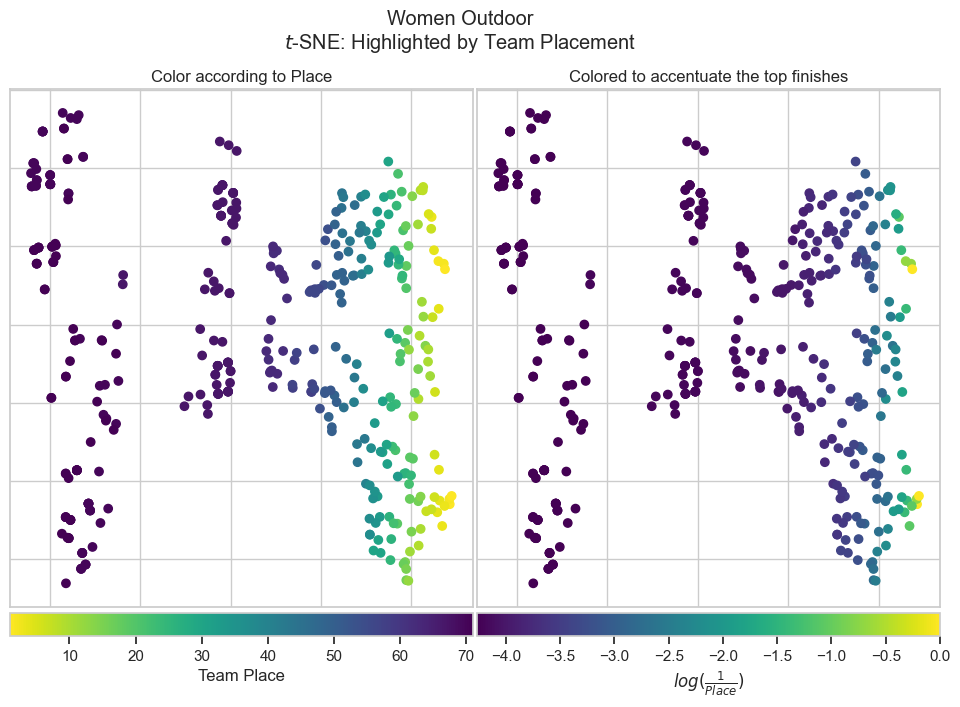

In [7]:
plt.figure(figsize=(12,8))
plt.suptitle('Women Outdoor\n$t$-SNE: Highlighted by Team Placement')

plot1_cmap = cmp['viridis'].reversed()
plt.subplot(1,2,1)
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['place'], 
            cmap=plot1_cmap)
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Team Place')
plt.title('Color according to Place')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

plt.subplot(1,2,2)
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=np.log(1 / dfs_f_o['place']), 
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label=r'$log(\frac{1}{Place})$')
plt.title('Colored to accentuate the top finishes')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

plt.subplots_adjust(wspace=0.01)

plt.show()

Scoring in the Top 10 seems to be possible in a variety of ways, but there are two distinct hubs for the top ~3.

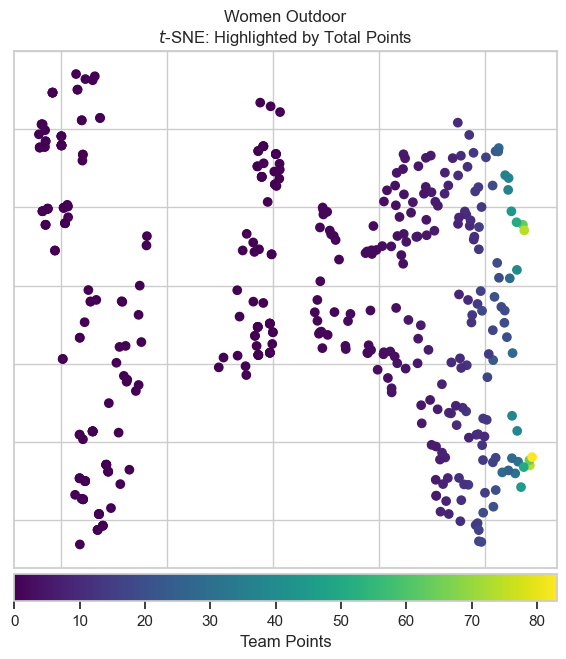

In [8]:
plt.figure(figsize=(7,8))
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['total_points'], 
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Team Points')
plt.title('Women Outdoor\n$t$-SNE: Highlighted by Total Points')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)
plt.show()

Again, we see there are clearly two distinct clusters that allow you to maximize points that will score you team podium finishes.

##### Theory 1: Specializing in Track or Field Points

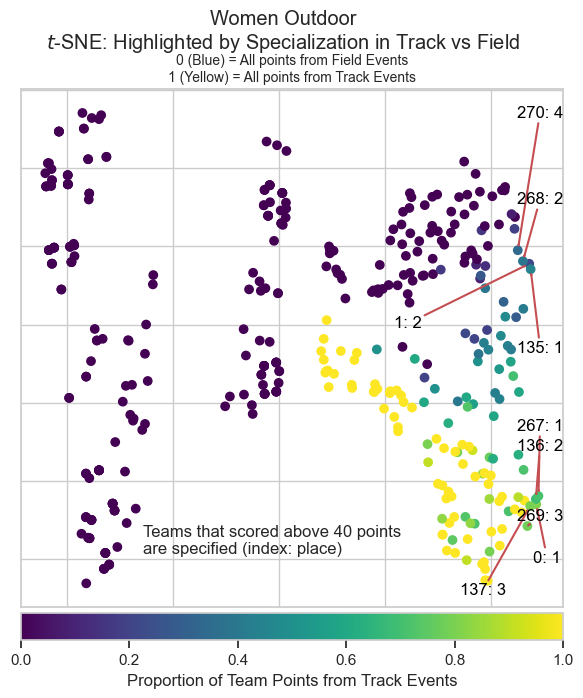

In [14]:
plt.figure(figsize=(7,8))
plt.scatter(x=dfs_f_o['tsne_x'], 
            y=dfs_f_o['tsne_y'], 
            c=dfs_f_o['track_vs_field_track_proportion'], 
            # s=1/dfs_f_o['place'] * 500,
            cmap='viridis')
plt.colorbar(orientation='horizontal', 
             pad=0.01,
             label='Proportion of Team Points from Track Events')
plt.suptitle('Women Outdoor\n$t$-SNE: Highlighted by Specialization in Track vs Field', 
              y=0.98)
plt.title('0 (Blue) = All points from Field Events\n1 (Yellow) = All points from Track Events',
          fontsize='small')
plt.tick_params(left=None, labelleft=False,
                bottom=None, labelbottom=False)

text_labels = []
for idx, row in dfs_f_o.iterrows():
    if row['total_points'] >= 40:
        text_labels.append(plt.text(row['tsne_x'], row['tsne_y'], f'''{idx}: {row['place']}''',
                                    c='black'))
adjust_text(text_labels, 
            only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="->", color='r', lw=1.5),
            force_text=(4,5))

plt.figtext(0.3, 0.3, s='Teams that scored above 40 points\nare specified (index: place)')

plt.show()

Clearly a strong degree of specialization, but both clusters of highest team points/placement involve points from both the track and the field.

In [10]:
dfs_f_o.sort_values(by=['place', 'total_points'], 
                    axis=0,
                    ascending=[True, False])[['place', 'team_w', 'total_points', 'track_vs_field_track_proportion']] \
        .head(9) \
        .style.format(precision=2)

,place,team_w,total_points,track_vs_field_track_proportion
267,1,Texas,83.00,0.71
0,1,USC,74.00,0.81
135,1,Florida,74.00,0.45
136,2,Texas,64.00,0.69
1,2,Texas A&M,63.00,0.22
268,2,Florida,51.00,0.39
137,3,Kentucky,50.00,0.80
269,3,Arkansas,46.00,0.78
2,3,Georgia,37.50,0.00


#### Team Points over Time

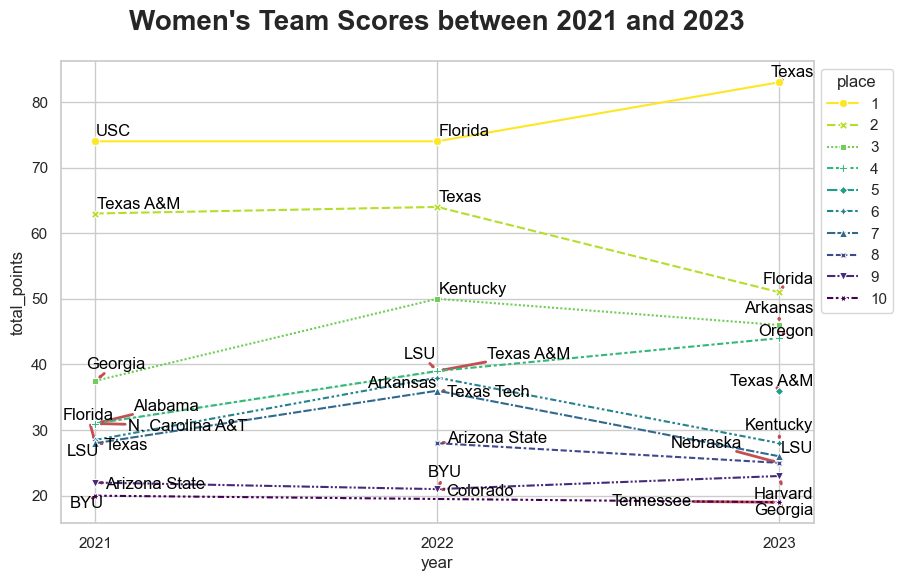

In [19]:
ts_f_o = dfs_f_o.loc[dfs_f_o['place'] <= 10].reset_index(drop=True)

color_vals = cmp['viridis'].reversed()(np.linspace(0, 1, num=10))

plt.figure(figsize=(6*1.618, 6))
ts_plot = sns.lineplot(x='year', 
                       y='total_points', 
                       hue='place', 
                       style='place',
                       markers=True,
                       data=ts_f_o, 
                       palette=list(color_vals))
ts_plot.set_xticks(range(2021,2024,1))
ts_plot.set_title('''Women's Team Scores between 2021 and 2023''', 
                  fontsize=20, 
                  y=1.05,
                  weight='bold')
sns.move_legend(obj=ts_plot, loc='upper left', bbox_to_anchor=(1, 1))

ts_labels=[]
for idx, row in ts_f_o.iterrows():
    ts_labels.append(plt.text(row['year'], row['total_points'], f'''{row['team_w']}''',
                                c='black'))
adjust_text(ts_labels, 
            only_move={'points':'xy', 'texts':'xy'},
            arrowprops=dict(arrowstyle="->", color='r', lw=2),
            force_text=(1,1))

plt.show()